In [14]:
import fastf1 as ff1
import pandas as pd
from fastf1 import utils
from matplotlib import pyplot as plt
from fastf1 import plotting

ff1.Cache.enable_cache('2023Australia') 
race = ff1.get_session(2023, 'Astralia', 'R')
race_laps = race.load_laps(with_telemetry=True)
race.load()
stint = 2

race_laps['LapTimeSeconds'] = race_laps['LapTime'].dt.total_seconds()
race_laps = race_laps.loc[(race_laps['PitOutTime'].isnull() & race_laps['PitInTime'].isnull() & race_laps['IsAccurate']==True) & race_laps['LapNumber'].between(11, 58, inclusive = True)]

race_laps = race_laps.loc[((race_laps['Driver'] == "VER")  & (race_laps['IsAccurate']==True)) | 
                          ((race_laps['Driver'] == "SAI")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "ALO")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "PER")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "LEC")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "HAM")  & (race_laps['IsAccurate']==True)) ] 


c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\core.py:1411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

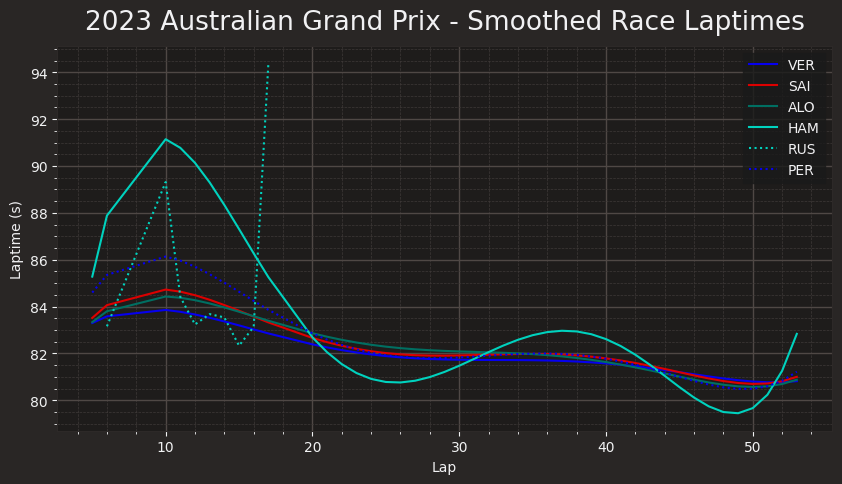

In [15]:
drivers_to_visualize = pd.unique(race_laps.Driver)

# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []
ff1.plotting.setup_mpl()
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 5]

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots()
# Lap-by-lap longrun comparison
for driver in drivers_to_visualize:
    driver_laps = race_laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    #y = seconds=driver_laps['LapTimeSeconds']
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax.plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    # Append labels
    ax.set(ylabel = 'Laptime (s)')
    ax.set(xlabel = 'Lap')
    
    # Set title
    ax.set_title(f"{race.event.year} {race.event.EventName} - Smoothed {race.name} Laptimes")

    # Generate legend
    ax.legend()
    visualized_teams.append(team)

In [32]:
import fastf1 as ff1
import pandas as pd
from fastf1 import utils
from matplotlib import pyplot as plt
from fastf1 import plotting

ff1.Cache.enable_cache('2023Australia') 
race = ff1.get_session(2023, 'Astralia', 'R')
race_laps = race.load_laps(with_telemetry=True)
race.load()
stint = 2

race_laps['LapTimeSeconds'] = race_laps['LapTime'].dt.total_seconds()
race_laps = race_laps.loc[(race_laps['PitOutTime'].isnull() & race_laps['PitInTime'].isnull() & race_laps['IsAccurate']==True) & race_laps['LapNumber'].between(11, 58, inclusive = True)]

race_laps = race_laps.loc[((race_laps['Driver'] == "VER")  & (race_laps['IsAccurate']==True)) | 
                          ((race_laps['Driver'] == "SAI")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "ALO")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "PER")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "LEC")  & (race_laps['IsAccurate']==True)) |
                          ((race_laps['Driver'] == "HAM")  & (race_laps['IsAccurate']==True)) ] 

c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
core        WARNING 	Failed to load data from Ergast API! (This is expected for recent sessions)
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\core.py:1411: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

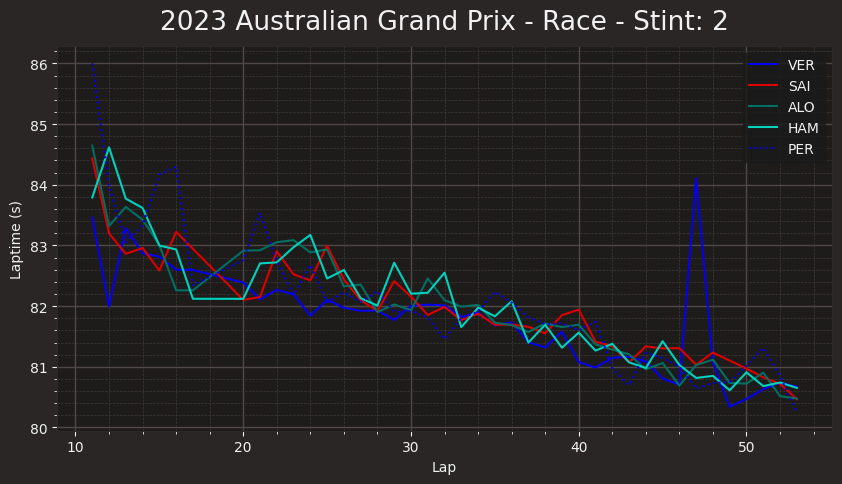

In [33]:
drivers_to_visualize = pd.unique(race_laps.Driver)


# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 5]

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots()
# Lap-by-lap longrun comparison
for driver in drivers_to_visualize:
    driver_laps = race_laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team', 'TyreLife']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    y = seconds=driver_laps['LapTimeSeconds']
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax.plot(x, y, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    # Append labels
    ax.set(ylabel = 'Laptime (s)')
    ax.set(xlabel = 'Lap')
    
    # Set title
    ax.set_title(f"{race.event.year} {race.event.EventName} - {race.name} - Stint: {stint}")

    # Generate legend
    ax.legend()
    visualized_teams.append(team)
    